<a href="https://colab.research.google.com/github/rahulkumar-datascientist/Detecting-Silent-Cardiac-Atrial-fibrillation-from-PPG-and-single-lead-ECG-Data-using-CNN-LSTM/blob/master/5.%20Galenband_ECG_CNN_LSTM_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import os, os.path
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

import zipfile
import re
import pickle
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional, LSTM, Activation, Dense, Dropout, BatchNormalization, InputLayer, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf


# Preparing the data according to the model Architecture

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Galenband Project

/content/drive/MyDrive/Colab Notebooks/Galenband Project


In [ ]:
# loading the saved dataframe

# Original Data
galenband_ECG_30k_segmented               = pd.read_pickle('Dataframes/galenband_ECG_30k_segmented.pkl')
# galenband_ECG_9k_segmented                = pd.read_pickle('Dataframes/galenband_ECG_9k_segmented.pkl')

# Butterworth All
galenband_ECG_30k_segmented_butter        = pd.read_pickle('Dataframes_1/galenband_ECG_30k_segmented_butter.pkl')
# galenband_ECG_9k_segmented_butter         = pd.read_pickle('Dataframes/galenband_ECG_9k_segmented_butter.pkl')

### Function to prepare train, test and validation data

In [ ]:
def prepare_data(dataset, seq_len, test_prop = 0.2, val_prop = 0.3):

  # splitting the data into train and test 
  train_set, test_set = train_test_split(dataset, test_size=test_prop, random_state=42, shuffle=True)

  # splitting the data into test and validation set
  val_set, test_set = train_test_split(test_set, test_size=val_prop, random_state=42, shuffle=True)
  
  train_set.reset_index(drop=True, inplace=True)
  test_set.reset_index(drop=True, inplace=True)
  val_set.reset_index(drop=True, inplace=True)

  # Splitting into input and output variables
  X_train = train_set.Signal
  Y_train = train_set.Class

  X_test = test_set.Signal
  Y_test = test_set.Class

  X_val = val_set.Signal
  Y_val = val_set.Class

  #####
  input_train   = np.zeros((len(X_train), seq_len), dtype='float32')
  output_train = np.zeros(len(Y_train), dtype='float32')

  input_test   = np.zeros((len(X_test), seq_len), dtype='float32')
  output_test = np.zeros(len(Y_test), dtype='float32')

  input_val   = np.zeros((len(X_val), seq_len), dtype='float32')
  output_val = np.zeros(len(Y_val), dtype='float32')

  # modeling X input
  for index, value in enumerate(X_train):
    input_train[index] = value


  for index, value in enumerate(X_test):
    input_test[index] = value


  for index, value in enumerate(X_val):
    input_val[index] = value

  
  # class 0 = Normal, class 1 = Afib
  # modeling Y output
  for index,value in enumerate(Y_train):
    if(value == 'N'):
      output_train[index] = 0
    else:
      output_train[index] = 1

  # modeling Y output
  for index,value in enumerate(Y_test):
    if(value == 'N'):
      output_test[index] = 0
    else:
      output_test[index] = 1

  # modeling Y output
  for index,value in enumerate(Y_val):
    if(value == 'N'):
      output_val[index] = 0
    else:
      output_val[index] = 1

  ## expanding the dimensions
  input_train = input_train.reshape(len(input_train), seq_len, 1)
  output_train = output_train.reshape(len(output_train), 1)

  input_test = input_test.reshape(len(input_test), seq_len, 1)
  output_test = output_test.reshape(len(output_test), 1)

  input_val = input_val.reshape(len(input_val), seq_len, 1)
  output_val = output_val.reshape(len(output_val), 1)

  ## return the data
  return (input_train, output_train, input_test, output_test, input_val, output_val)



# 1. Models with 30k sample sequence

## 1.1 Model using Normal data

In [ ]:
input_train, output_train, input_test, output_test, input_val, output_val = \
prepare_data(galenband_ECG_30k_segmented, 30000, test_prop = 0.3, val_prop = 0.3)

In [ ]:
print("input train shape:\t ", input_train.shape)
print("output train shape:\t ", output_train.shape)

print("\ninput test shape:\t ", input_test.shape)
print("output test shape:\t ", output_test.shape)

print("\ninput val shape:\t ", input_val.shape)
print("output val shape:\t ", output_val.shape)

input train shape:	  (1088, 30000, 1)
output train shape:	  (1088, 1)

input test shape:	  (141, 30000, 1)
output test shape:	  (141, 1)

input val shape:	  (326, 30000, 1)
output val shape:	  (326, 1)


In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 1.0018416206261511, 1: 0.998165137614679}

In [ ]:
# Defining parameter values
epochs          = 300
batch_size      = 32

In [ ]:
# # Load the saved model
# base_model  = keras.models.load_model('Training_models/ECG/Model 1/ECG.epoch_25.TL_0.2977.VL_0.2020.TA_0.93.VA_0.94.hdf5')
# # weights     = base_model.get_weights()

In [ ]:
ECG_30k_segmented_model = Sequential()

# 64, 64, 32, 16, 8, 32

input_shape = (30000, 1)
ECG_30k_segmented_model.add(InputLayer(input_shape=input_shape))

ECG_30k_segmented_model.add(Conv1D(64, 10,padding='causal', activation="tanh"))
ECG_30k_segmented_model.add(MaxPooling1D(4))

ECG_30k_segmented_model.add(Conv1D(64, 10,padding='same', activation="tanh"))
ECG_30k_segmented_model.add(MaxPooling1D(4))

ECG_30k_segmented_model.add(LSTM(32,activation = "tanh", return_sequences = True))
ECG_30k_segmented_model.add(LSTM(16, activation = "tanh", return_sequences = True))
ECG_30k_segmented_model.add(LSTM(8, activation = "tanh"))

ECG_30k_segmented_model.add(Dense(32, activation='tanh'))
ECG_30k_segmented_model.add(BatchNormalization())
ECG_30k_segmented_model.add(Dense(1, activation = 'sigmoid'))

ECG_30k_segmented_model.summary()

# set weights
# ECG_30k_segmented_model.set_weights(weights)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 30000, 64)         704       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7500, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7500, 64)          41024     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1875, 64)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1875, 32)          12416     
_________________________________________________________________
lstm_4 (LSTM)                (None, 1875, 16)          3136      
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                

In [ ]:
# model training configuration 
ECG_30k_segmented_model.compile(optimizer = tf.keras.optimizers.Adam(),
                                loss      = keras.losses.BinaryCrossentropy(),
                                metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 25, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
# early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 35, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/ECG/Model_1/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
ECG_30k_segmented_model_his = ECG_30k_segmented_model.fit(input_train, output_train,
                                                          batch_size = batch_size , epochs = epochs, 
                                                          validation_data = (input_val, output_val),
                                                          # class_weight=class_weight_dict_1,
                                                          callbacks=[reduce_lr,model_save])

ECG_30k_segmented_model.save('Training_models/ECG/Model_1/ECG.final_run.hdf5')                  

Epoch 1/300
34/34 [==============================] - 27s 254ms/step - loss: 0.7102 - binary_accuracy: 0.5386 - val_loss: 0.6908 - val_binary_accuracy: 0.4785
Epoch 2/300
34/34 [==============================] - 8s 222ms/step - loss: 0.6671 - binary_accuracy: 0.5772 - val_loss: 0.6890 - val_binary_accuracy: 0.4785
Epoch 3/300
34/34 [==============================] - 8s 222ms/step - loss: 0.6461 - binary_accuracy: 0.6011 - val_loss: 0.6787 - val_binary_accuracy: 0.6288
Epoch 4/300
34/34 [==============================] - 8s 222ms/step - loss: 0.6358 - binary_accuracy: 0.6305 - val_loss: 0.6757 - val_binary_accuracy: 0.6227
Epoch 5/300
34/34 [==============================] - 8s 223ms/step - loss: 0.6199 - binary_accuracy: 0.6471 - val_loss: 0.6712 - val_binary_accuracy: 0.4816
Epoch 6/300
34/34 [==============================] - 8s 223ms/step - loss: 0.6019 - binary_accuracy: 0.6728 - val_loss: 0.6511 - val_binary_accuracy: 0.6810
Epoch 7/300
34/34 [==============================] - 8s 2

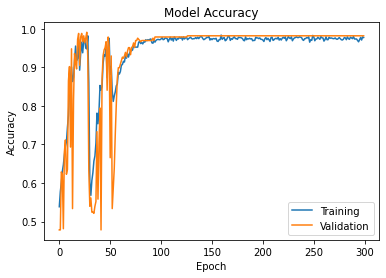

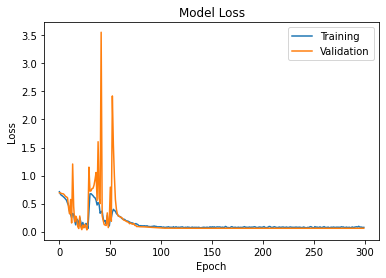

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = ECG_30k_segmented_model_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
# Load the Final model
model = keras.models.load_model('Training_models/ECG/Model_1/ECG.final_run.hdf5')
# model = ECG_30k_segmented_model

test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

Test loss: 0.045619722455739975
Test accuracy: 0.978723406791687


In [ ]:
yhat = (model.predict(input_test) > 0.5).astype("int32")

conf_matrix = confusion_matrix(output_test,yhat)

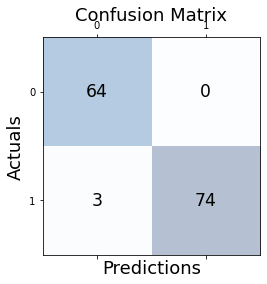

In [ ]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

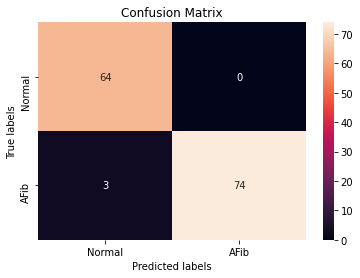

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'AFib']); ax.yaxis.set_ticklabels(['Normal', 'AFib']);


In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))

Accuracy:		 0.9787
Precision:		 1.0
Recall: 		 0.961
F1 score:		 0.9801


## 1.3 Model using All Butterworth 

In [ ]:
input_train, output_train, input_test, output_test, input_val, output_val = \
prepare_data(galenband_ECG_30k_segmented_butter, 30000, test_prop = 0.25, val_prop = 0.28)

In [ ]:
print("input train shape:\t ", input_train.shape)
print("output train shape:\t ", output_train.shape)

print("\ninput test shape:\t ", input_test.shape)
print("output test shape:\t ", output_test.shape)

print("\ninput val shape:\t ", input_val.shape)
print("output val shape:\t ", output_val.shape)

input train shape:	  (1492, 30000, 1)
output train shape:	  (1492, 1)

input test shape:	  (140, 30000, 1)
output test shape:	  (140, 1)

input val shape:	  (358, 30000, 1)
output val shape:	  (358, 1)


In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 0.9010349288486417, 1: 1.1233870967741935}

In [ ]:
# Defining parameter values
epochs          = 300
batch_size      = 32

In [ ]:
# # Load the saved model
# base_model  = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 4_1/ECG.epoch_25.TL_0.2977.VL_0.2020.TA_0.93.VA_0.94.hdf5')
# weights     = base_model.get_weights()

In [ ]:
ECG_30k_butter = Sequential()

# 64, 64, 32, 16, 8, 32

input_shape = (30000, 1)
ECG_30k_butter.add(InputLayer(input_shape=input_shape))

ECG_30k_butter.add(Conv1D(64, 10,padding='causal', activation="tanh"))
ECG_30k_butter.add(MaxPooling1D(4))

ECG_30k_butter.add(Conv1D(64, 10,padding='same', activation="tanh"))
ECG_30k_butter.add(MaxPooling1D(4))

ECG_30k_butter.add(LSTM(32,activation = "tanh", return_sequences = True))
ECG_30k_butter.add(LSTM(16, activation = "tanh", return_sequences = True))
ECG_30k_butter.add(LSTM(8, activation = "tanh"))

ECG_30k_butter.add(Dense(32, activation='tanh'))
ECG_30k_butter.add(BatchNormalization())
ECG_30k_butter.add(Dense(1, activation = 'sigmoid'))

ECG_30k_butter.summary()

# set weights
# ECG_30k_butter.set_weights(weights)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30000, 64)         704       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7500, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7500, 64)          41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1875, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1875, 32)          12416     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1875, 16)          3136      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 8

In [ ]:
# model training configuration 
ECG_30k_butter.compile(optimizer = tf.keras.optimizers.Adam(),
                                loss      = keras.losses.BinaryCrossentropy(),
                                metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 25, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
# early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 35, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/ECG/Model_2/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
ECG_30k_butter_his = ECG_30k_butter.fit(input_train, output_train,
                                                          batch_size = batch_size , epochs = epochs, 
                                                          validation_data = (input_val, output_val),
                                                          # class_weight=class_weight_dict_1,
                                                          callbacks=[reduce_lr,model_save])


ECG_30k_butter.save('Training_models/ECG/Model_2/ECG.final_run.hdf5')

Epoch 1/300
44/44 [==============================] - 30s 226ms/step - loss: 0.6897 - binary_accuracy: 0.5671 - val_loss: 0.6758 - val_binary_accuracy: 0.5924
Epoch 2/300
44/44 [==============================] - 9s 201ms/step - loss: 0.6546 - binary_accuracy: 0.6289 - val_loss: 0.6671 - val_binary_accuracy: 0.5966
Epoch 3/300
44/44 [==============================] - 9s 201ms/step - loss: 0.5812 - binary_accuracy: 0.6956 - val_loss: 0.7631 - val_binary_accuracy: 0.4076
Epoch 4/300
44/44 [==============================] - 9s 201ms/step - loss: 0.4421 - binary_accuracy: 0.8026 - val_loss: 0.4477 - val_binary_accuracy: 0.8655
Epoch 5/300
44/44 [==============================] - 9s 202ms/step - loss: 0.2920 - binary_accuracy: 0.8780 - val_loss: 0.2995 - val_binary_accuracy: 0.9160
Epoch 6/300
44/44 [==============================] - 9s 201ms/step - loss: 0.1958 - binary_accuracy: 0.9275 - val_loss: 0.7449 - val_binary_accuracy: 0.5840
Epoch 7/300
44/44 [==============================] - 9s 2

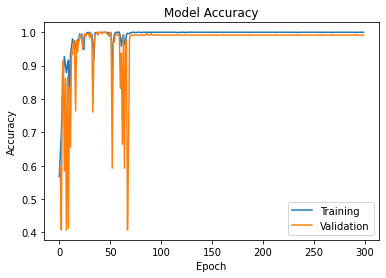

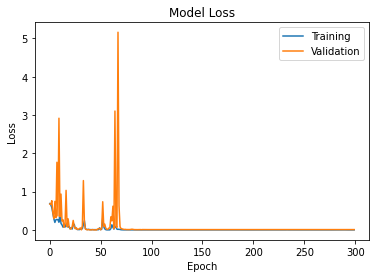

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = ECG_30k_butter_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
# Load the Final model
model = keras.models.load_model('Training_models/ECG/Model_2/ECG.final_run.hdf5')

test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

Test loss: 0.0001774470292730257
Test accuracy: 1.0


In [ ]:
yhat = (model.predict(input_test) > 0.5).astype("int32")

conf_matrix = confusion_matrix(output_test,yhat)

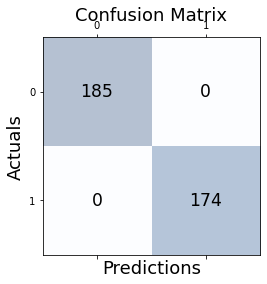

In [ ]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

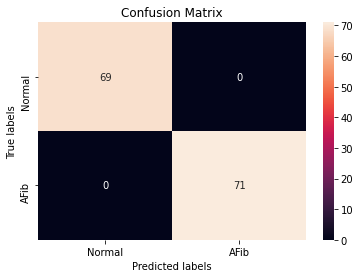

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'AFib']); ax.yaxis.set_ticklabels(['Normal', 'AFib']);


In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))

Accuracy:		 1.0
Precision:		 1.0
Recall: 		 1.0
F1 score:		 1.0


## 1.4 Model using Afib Baseline Wander 

In [ ]:
input_train, output_train, input_test, output_test, input_val, output_val = \
prepare_data(galenband_ECG_30k_segmented_wander_afib, 30000, test_prop = 0.3, val_prop = 0.6)

In [ ]:
print("input train shape:\t ", input_train.shape)
print("output train shape:\t ", output_train.shape)

print("\ninput test shape:\t ", input_test.shape)
print("output test shape:\t ", output_test.shape)

print("\ninput val shape:\t ", input_val.shape)
print("output val shape:\t ", output_val.shape)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

In [ ]:
# Defining parameter values
epochs          = 200
batch_size      = 16

In [ ]:
# Load the saved model
base_model  = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 4_1/ECG.epoch_25.TL_0.2977.VL_0.2020.TA_0.93.VA_0.94.hdf5')
weights     = base_model.get_weights()

In [ ]:
ECG_30k_wander_afib = Sequential()

# 64, 64, 32, 16, 8, 32

input_shape = (30000, 1)
ECG_30k_wander_afib.add(InputLayer(input_shape=input_shape))

ECG_30k_wander_afib.add(Conv1D(64, 2,padding='causal', activation="tanh"))
ECG_30k_wander_afib.add(MaxPooling1D(2))

ECG_30k_wander_afib.add(Conv1D(64, 2,padding='same', activation="tanh"))
ECG_30k_wander_afib.add(MaxPooling1D(2))

ECG_30k_wander_afib.add(LSTM(32,activation = "tanh", return_sequences = True))
ECG_30k_wander_afib.add(LSTM(16, activation = "tanh", return_sequences = True))
ECG_30k_wander_afib.add(LSTM(8, activation = "tanh"))

ECG_30k_wander_afib.add(Dense(32, activation='tanh'))
ECG_30k_wander_afib.add(BatchNormalization())
ECG_30k_wander_afib.add(Dense(1, activation = 'sigmoid'))

ECG_30k_wander_afib.summary()

# set weights
ECG_30k_wander_afib.set_weights(weights)

In [ ]:
# model training configuration 
ECG_30k_wander_afib.compile(optimizer = keras.optimizers.Adam(),
                                loss      = keras.losses.BinaryCrossentropy(),
                                metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 25, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 35, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/ECG_30k_wander_afib/Model_1/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
ECG_30k_wander_afib_his = ECG_30k_wander_afib.fit(input_train, output_train,
                                                          batch_size = batch_size , epochs = epochs, 
                                                          validation_data = (input_val, output_val),
                                                          # class_weight=class_weight_dict_1,
                                                          callbacks=[early_stop, reduce_lr,model_save])

ECG_30k_wander_afib.save('Training_models/ECG_30k_wander_afib/Model_1/ECG.final_run.hdf5')

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = ECG_30k_wander_afib_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
# Load the Final model
model = ECG_30k_wander_afib

test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

In [ ]:
yhat = model.predict_classes(input_test)

conf_matrix = confusion_matrix(output_test,yhat)

In [ ]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))

## 1.5 Model using all Baseline Wander 

In [ ]:
input_train, output_train, input_test, output_test, input_val, output_val = \
prepare_data(galenband_ECG_30k_segmented_wander, 30000, test_prop = 0.3, val_prop = 0.6)

In [ ]:
print("input train shape:\t ", input_train.shape)
print("output train shape:\t ", output_train.shape)

print("\ninput test shape:\t ", input_test.shape)
print("output test shape:\t ", output_test.shape)

print("\ninput val shape:\t ", input_val.shape)
print("output val shape:\t ", output_val.shape)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

In [ ]:
# Defining parameter values
epochs          = 200
batch_size      = 16

In [ ]:
# Load the saved model
base_model  = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 4_1/ECG.epoch_25.TL_0.2977.VL_0.2020.TA_0.93.VA_0.94.hdf5')
weights     = base_model.get_weights()

In [ ]:
ECG_30k_wander = Sequential()

# 64, 64, 32, 16, 8, 32

input_shape = (30000, 1)
ECG_30k_wander.add(InputLayer(input_shape=input_shape))

ECG_30k_wander.add(Conv1D(64, 2,padding='causal', activation="tanh"))
ECG_30k_wander.add(MaxPooling1D(2))

ECG_30k_wander.add(Conv1D(64, 2,padding='same', activation="tanh"))
ECG_30k_wander.add(MaxPooling1D(2))

ECG_30k_wander.add(LSTM(32,activation = "tanh", return_sequences = True))
ECG_30k_wander.add(LSTM(16, activation = "tanh", return_sequences = True))
ECG_30k_wander.add(LSTM(8, activation = "tanh"))

ECG_30k_wander.add(Dense(32, activation='tanh'))
ECG_30k_wander.add(BatchNormalization())
ECG_30k_wander.add(Dense(1, activation = 'sigmoid'))

ECG_30k_wander.summary()

# set weights
ECG_30k_wander.set_weights(weights)

In [ ]:
# model training configuration 
ECG_30k_wander.compile(optimizer = keras.optimizers.Adam(),
                                loss      = keras.losses.BinaryCrossentropy(),
                                metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 25, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 35, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/ECG_30k_wander/Model_1/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
ECG_30k_wander_his = ECG_30k_wander.fit(input_train, output_train,
                                                          batch_size = batch_size , epochs = epochs, 
                                                          validation_data = (input_val, output_val),
                                                          # class_weight=class_weight_dict_1,
                                                          callbacks=[early_stop, reduce_lr,model_save])

ECG_30k_wander.save('Training_models/ECG_30k_wander/Model_1/ECG.final_run.hdf5')

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = ECG_30k_wander_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
# Load the Final model
model = ECG_30k_wander

test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

In [ ]:
yhat = model.predict_classes(input_test)

conf_matrix = confusion_matrix(output_test,yhat)

In [ ]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))

In [ ]:
ECG_30k_segmented_model.save('Training_models/ECG_30k_original/Model_1/ECG.final_run.hdf5')

# 1. Models with 9k sample sequence

## 1.1 Model using Normal data

In [ ]:
input_train, output_train, input_test, output_test, input_val, output_val = \
prepare_data(galenband_ECG_9k_segmented, 9000, test_prop = 0.3, val_prop = 0.60)

In [ ]:
print("input train shape:\t ", input_train.shape)
print("output train shape:\t ", output_train.shape)

print("\ninput test shape:\t ", input_test.shape)
print("output test shape:\t ", output_test.shape)

print("\ninput val shape:\t ", input_val.shape)
print("output val shape:\t ", output_val.shape)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

In [ ]:
# Defining parameter values
epochs          = 200
batch_size      = 16

In [ ]:
# Load the saved model
base_model  = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 4_1/ECG.epoch_25.TL_0.2977.VL_0.2020.TA_0.93.VA_0.94.hdf5')
weights     = base_model.get_weights()

In [ ]:
ECG_9k_segmented_model = Sequential()

# 64, 64, 32, 16, 8, 32

input_shape = (9000, 1)
ECG_9k_segmented_model.add(InputLayer(input_shape=input_shape))

ECG_9k_segmented_model.add(Conv1D(64, 2,padding='causal', activation="tanh"))
ECG_9k_segmented_model.add(MaxPooling1D(2))

ECG_9k_segmented_model.add(Conv1D(64, 2,padding='same', activation="tanh"))
ECG_9k_segmented_model.add(MaxPooling1D(2))

ECG_9k_segmented_model.add(LSTM(32,activation = "tanh", return_sequences = True))
ECG_9k_segmented_model.add(LSTM(16, activation = "tanh", return_sequences = True))
ECG_9k_segmented_model.add(LSTM(8, activation = "tanh"))

ECG_9k_segmented_model.add(Dense(32, activation='tanh'))
ECG_9k_segmented_model.add(BatchNormalization())
ECG_9k_segmented_model.add(Dense(1, activation = 'sigmoid'))

ECG_9k_segmented_model.summary()

# set weights
ECG_9k_segmented_model.set_weights(weights)

In [ ]:
# model training configuration 
ECG_9k_segmented_model.compile(optimizer = keras.optimizers.Adam(),
                                loss      = keras.losses.BinaryCrossentropy(),
                                metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 25, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 35, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/ECG_9k_original/Model_1/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
ECG_9k_segmented_model_his = ECG_9k_segmented_model.fit(input_train, output_train,
                                                          batch_size = batch_size , epochs = epochs, 
                                                          validation_data = (input_val, output_val),
                                                          # class_weight=class_weight_dict_1,
                                                          callbacks=[early_stop, reduce_lr,model_save])

ECG_9k_segmented_model.save('Training_models/ECG_9k_original/Model_1/ECG.final_run.hdf5')

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = ECG_9k_segmented_model_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
# Load the Final model
# model = keras.models.load_model('Training_models/ECG_30k_original/Model_1/ECG.epoch_48.TL_0.0258.VL_0.0084.TA_1.00.VA_1.00.hdf5')
model = ECG_9k_segmented_model

test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

In [ ]:
yhat = model.predict_classes(input_test)

conf_matrix = confusion_matrix(output_test,yhat)

In [ ]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))

## 1.2 Model using All Butterworth Band Pass data

In [ ]:
input_train, output_train, input_test, output_test, input_val, output_val = \
prepare_data(galenband_ECG_9k_segmented_butter, 9000, test_prop = 0.3, val_prop = 0.6)

In [ ]:
print("input train shape:\t ", input_train.shape)
print("output train shape:\t ", output_train.shape)

print("\ninput test shape:\t ", input_test.shape)
print("output test shape:\t ", output_test.shape)

print("\ninput val shape:\t ", input_val.shape)
print("output val shape:\t ", output_val.shape)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

In [ ]:
# Defining parameter values
epochs          = 200
batch_size      = 16

In [ ]:
# Load the saved model
base_model  = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 4_1/ECG.epoch_25.TL_0.2977.VL_0.2020.TA_0.93.VA_0.94.hdf5')
weights     = base_model.get_weights()

In [ ]:
ECG_9k_butter_model = Sequential()

# 64, 64, 32, 16, 8, 32

input_shape = (9000, 1)
ECG_9k_butter_model.add(InputLayer(input_shape=input_shape))

ECG_9k_butter_model.add(Conv1D(64, 2,padding='causal', activation="tanh"))
ECG_9k_butter_model.add(MaxPooling1D(2))

ECG_9k_butter_model.add(Conv1D(64, 2,padding='same', activation="tanh"))
ECG_9k_butter_model.add(MaxPooling1D(2))

ECG_9k_butter_model.add(LSTM(32,activation = "tanh", return_sequences = True))
ECG_9k_butter_model.add(LSTM(16, activation = "tanh", return_sequences = True))
ECG_9k_butter_model.add(LSTM(8, activation = "tanh"))

ECG_9k_butter_model.add(Dense(32, activation='tanh'))
ECG_9k_butter_model.add(BatchNormalization())
ECG_9k_butter_model.add(Dense(1, activation = 'sigmoid'))

ECG_9k_butter_model.summary()

# set weights
ECG_9k_butter_model.set_weights(weights)

In [ ]:
# model training configuration 
ECG_9k_butter_model.compile(optimizer = keras.optimizers.Adam(),
                                loss      = keras.losses.BinaryCrossentropy(),
                                metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 25, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 35, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/ECG_9k_butter/Model_1/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
ECG_9k_butter_model_his = ECG_9k_butter_model.fit(input_train, output_train,
                                                          batch_size = batch_size , epochs = epochs, 
                                                          validation_data = (input_val, output_val),
                                                          # class_weight=class_weight_dict_1,
                                                          callbacks=[early_stop, reduce_lr,model_save])

ECG_9k_butter_model.save('Training_models/ECG_9k_butter/Model_1/ECG.final_run.hdf5')

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = ECG_9k_butter_model_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
# Load the Final model
# model = keras.models.load_model('Training_models/ECG_30k_original/Model_1/ECG.epoch_48.TL_0.0258.VL_0.0084.TA_1.00.VA_1.00.hdf5')
model = ECG_9k_butter_model
test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

In [ ]:
yhat = model.predict_classes(input_test)

conf_matrix = confusion_matrix(output_test,yhat)

In [ ]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))

# MISC

### again

In [ ]:
##################################################################

In [ ]:
input_train, output_train, input_test, output_test, input_val, output_val = \
prepare_data(galenband_ECG_30k_segmented, 30000, test_prop = 0.3, val_prop = 0.6)

In [ ]:
print("input train shape:\t ", input_train.shape)
print("output train shape:\t ", output_train.shape)

print("\ninput test shape:\t ", input_test.shape)
print("output test shape:\t ", output_test.shape)

print("\ninput val shape:\t ", input_val.shape)
print("output val shape:\t ", output_val.shape)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

In [ ]:
# Defining parameter values
epochs          = 200
batch_size      = 16

In [ ]:
# Load the saved model
base_model  = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 4_1/ECG.epoch_25.TL_0.2977.VL_0.2020.TA_0.93.VA_0.94.hdf5')
weights     = base_model.get_weights()

In [ ]:
ECG_30k_segmented_model = Sequential()

# 64, 64, 32, 16, 8, 32

input_shape = (30000, 1)
ECG_30k_segmented_model.add(InputLayer(input_shape=input_shape))

ECG_30k_segmented_model.add(Conv1D(64, 2,padding='causal', activation="tanh"))
ECG_30k_segmented_model.add(MaxPooling1D(2))

ECG_30k_segmented_model.add(Conv1D(64, 2,padding='same', activation="tanh"))
ECG_30k_segmented_model.add(MaxPooling1D(2))

ECG_30k_segmented_model.add(LSTM(32,activation = "tanh", return_sequences = True))
ECG_30k_segmented_model.add(LSTM(16, activation = "tanh", return_sequences = True))
ECG_30k_segmented_model.add(LSTM(8, activation = "tanh"))

ECG_30k_segmented_model.add(Dense(32, activation='tanh'))
ECG_30k_segmented_model.add(BatchNormalization())
ECG_30k_segmented_model.add(Dense(1, activation = 'sigmoid'))

ECG_30k_segmented_model.summary()

# set weights
ECG_30k_segmented_model.set_weights(weights)

In [ ]:
# model training configuration 
ECG_30k_segmented_model.compile(optimizer = keras.optimizers.Adam(),
                                loss      = keras.losses.BinaryCrossentropy(),
                                metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 20, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 25, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/ECG_30k_original/Model_2/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
ECG_30k_segmented_model_his = ECG_30k_segmented_model.fit(input_train, output_train,
                                                          batch_size = batch_size , epochs = epochs, 
                                                          validation_data = (input_val, output_val),
                                                          # class_weight=class_weight_dict_1,
                                                          callbacks=[early_stop, reduce_lr,model_save])

In [ ]:
ECG_30k_segmented_model.save('Training_models/ECG_30k_original/Model_2/ECG.final_run.hdf5')

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = ECG_30k_segmented_model_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
# Load the Final model
model = keras.models.load_model('Training_models/ECG_30k_original/Model_2/ECG.epoch_39.TL_0.1255.VL_0.0508.TA_0.96.VA_0.99.hdf5')

test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

In [ ]:
yhat = model.predict_classes(input_test)

conf_matrix = confusion_matrix(output_test,yhat)

In [ ]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))

## 1.2 Model using Afib Butterworth 

In [ ]:
input_train, output_train, input_test, output_test, input_val, output_val = \
prepare_data(galenband_ECG_30k_segmented_butter_afib, 30000, test_prop = 0.3, val_prop = 0.6)

In [ ]:
print("input train shape:\t ", input_train.shape)
print("output train shape:\t ", output_train.shape)

print("\ninput test shape:\t ", input_test.shape)
print("output test shape:\t ", output_test.shape)

print("\ninput val shape:\t ", input_val.shape)
print("output val shape:\t ", output_val.shape)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(output_train.flatten()), output_train.flatten())

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

In [ ]:
# Defining parameter values
epochs          = 200
batch_size      = 16

In [ ]:
# Load the saved model
base_model  = keras.models.load_model('Training_models/CNN-LSTM Normal data/Model 4_1/ECG.epoch_25.TL_0.2977.VL_0.2020.TA_0.93.VA_0.94.hdf5')
weights     = base_model.get_weights()

In [ ]:
ECG_30k_butter_afib = Sequential()

# 64, 64, 32, 16, 8, 32

input_shape = (30000, 1)
ECG_30k_butter_afib.add(InputLayer(input_shape=input_shape))

ECG_30k_butter_afib.add(Conv1D(64, 2,padding='causal', activation="tanh"))
ECG_30k_butter_afib.add(MaxPooling1D(2))

ECG_30k_butter_afib.add(Conv1D(64, 2,padding='same', activation="tanh"))
ECG_30k_butter_afib.add(MaxPooling1D(2))

ECG_30k_butter_afib.add(LSTM(32,activation = "tanh", return_sequences = True))
ECG_30k_butter_afib.add(LSTM(16, activation = "tanh", return_sequences = True))
ECG_30k_butter_afib.add(LSTM(8, activation = "tanh"))

ECG_30k_butter_afib.add(Dense(32, activation='tanh'))
ECG_30k_butter_afib.add(BatchNormalization())
ECG_30k_butter_afib.add(Dense(1, activation = 'sigmoid'))

ECG_30k_butter_afib.summary()

# set weights
ECG_30k_butter_afib.set_weights(weights)

In [ ]:
# model training configuration 
ECG_30k_butter_afib.compile(optimizer = keras.optimizers.Adam(),
                                loss      = keras.losses.BinaryCrossentropy(),
                                metrics   = [keras.metrics.BinaryAccuracy()])

#SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Callback to reduce the learning rate when the validation loss has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 25, mode = 'min')

# Callback to stop training the model when the validation loss has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 35, mode = 'min')

# CHECKPOINT callback
filepath = "Training_models/ECG_30k_butter_afib/Model_1/ECG.epoch_{epoch:02d}.TL_{loss:.4f}.VL_{val_loss:.4f}.TA_{binary_accuracy:.2f}.VA_{val_binary_accuracy:.2f}.hdf5"

# Save training model when there is an improvement in validation_accuracy from the previous checkpint
model_save = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor = 'val_binary_accuracy',
                                             save_best_only=True, 
                                             mode = 'max')




In [ ]:
# Fitting the model
ECG_30k_butter_afib_his = ECG_30k_butter_afib.fit(input_train, output_train,
                                                          batch_size = batch_size , epochs = epochs, 
                                                          validation_data = (input_val, output_val),
                                                          # class_weight=class_weight_dict_1,
                                                          callbacks=[early_stop, reduce_lr,model_save])

ECG_30k_butter_afib.save('Training_models/ECG_30k_butter_afib/Model_1/ECG.final_run.hdf5')

In [ ]:
# list all data in history
# print(model_history.history.keys())

model_history = ECG_30k_butter_afib_his

# summarize history for accuracy
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([0.60, 1.00])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

Model Evaluation

In [ ]:
# Load the Final model
model = keras.models.load_model('Training_models/ECG_30k_butter_afib/Model_1/ECG.epoch_14.TL_0.0600.VL_0.0162.TA_0.99.VA_1.00.hdf5')

test_scores = model.evaluate(input_test, output_test, verbose = 0)
print("Test loss:", test_scores[0])               # 0.1305         
print("Test accuracy:", test_scores[1])           # 0.9650

In [ ]:
yhat = model.predict_classes(input_test)

conf_matrix = confusion_matrix(output_test,yhat)

In [ ]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
accuracy = accuracy_score(output_test, yhat)
print('Accuracy:\t\t', round(accuracy,4))

# precision tp / (tp + fp)
precision = precision_score(output_test, yhat)
print('Precision:\t\t', round(precision,4))

# recall: tp / (tp + fn)
recall = recall_score(output_test, yhat)
print('Recall: \t\t', round(recall,4))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(output_test, yhat)
print('F1 score:\t\t', round(f1,4))